In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 

from models import sentimentAnalyze
from run_model import run_model
from my_dataset import MyDataset
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

trainData  = pd.read_csv('../data/train_E6oV3lV.csv')
testData = pd.read_csv('../data/test_tweets_anuFYb8.csv')


dataSet = trainData.append(testData, ignore_index=True)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@user)
dataSet['tidy_tweet'] = np.vectorize(remove_pattern)(dataSet['tweet'], "@[\w]*")

# remove special characters, numbers, punctuations
dataSet['tidy_tweet'] = dataSet['tidy_tweet'].str.replace("[^a-zA-Z]", " ")

# remove short word
dataSet['tidy_tweet'] = dataSet['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# # tokenize
# tokenized_Data = dataSet['tidy_tweet'].apply(lambda x: x.split())

import spacy
nlp = spacy.load('en_core_web_sm')
combi1 = dataSet['tidy_tweet'].copy()
for i, sentence in enumerate(dataSet['tidy_tweet']):
    combi1[i] = nlp(sentence)


# for i in range(len(tokenized_Data)):
#     tokenized_Data[i] = ' '.join(tokenized_Data[i])
# dataSet['tidy_tweet'] = tokenized_Data
combi1 = combi1.astype(str)
dataSet['tidy_tweet'] = combi1
dataSet.head(20)





<ipython-input-1-77718aa33965>:34: FutureWarning: The default value of regex will change from True to False in a future version.
  dataSet['tidy_tweet'] = dataSet['tidy_tweet'].str.replace("[^a-zA-Z]", " ")


,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cause they offer wheelchair...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fare talking before they leave chaos disp...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,next school year year exams think about that s...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,love land allin cavs champions cleveland cleve...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here


In [2]:
from tqdm import tqdm
import codecs, sys

MAX_NB_WORDS = 100000

embeddings_index = {}
f = codecs.open('../data/glove.twitter.27B/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

1193515it [00:56, 21206.79it/s]


1
S:\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


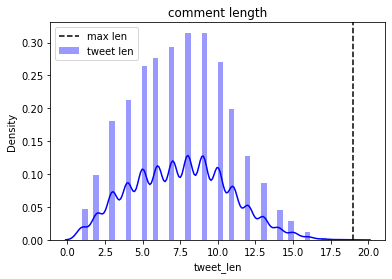

In [4]:
y_train = dataSet['label']
dataSet['tweet_len'] = dataSet['tidy_tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(dataSet['tweet_len'].mean() + dataSet['tweet_len'].std()).astype(int)
max_seq_len = dataSet['tweet_len'].max()
min_seq_len = dataSet['tweet_len'].min()
print(min_seq_len)
sns.distplot(dataSet['tweet_len'], hist=True, kde=True, color='b', label='tweet len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [5]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle 
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

# nltk.download('stopwords')
# nltk.download('punkt')

# raw_docs = dataSet['tidy_tweet'].tolist()
# num_classes = 2
# print("pre-processing train data...")

# processed_docs = []
# for doc in tqdm(raw_docs):
#     tokens = word_tokenize(doc)
#     filtered = [word for word in tokens if word not in stop_words]
#     processed_docs.append(" ".join(filtered))
# #end for



# print("tokenizing input data...")
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
# tokenizer.fit_on_texts(processed_docs)  #leaky
# word_seq = tokenizer.texts_to_sequences(processed_docs)
# word_index = tokenizer.word_index
# print("dictionary size: ", len(word_index))

#pad sequences
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(dataSet['tidy_tweet'])  #leaky
word_seq = tokenizer.texts_to_sequences(dataSet['tidy_tweet'])
print(word_seq[0])
word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len, padding = 'post')
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))
print(word_seq.shape)
print(word_seq[0])
print(dataSet['tweet_len'][0])
print(len(word_index))

[10, 26, 11762, 2572, 7533, 158, 165, 9117]
dictionary size:  46133
(49159, 19)
[   10    26 11762  2572  7533   158   165  9117     0     0     0     0
     0     0     0     0     0     0     0]
8
46133


In [6]:
#training params
batch_size = 256 
num_epochs = 100

#model parameters
num_filters = 64 
embed_dim = 100 
weight_decay = 1e-4

#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in tqdm(word_index.items()):
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print(embedding_matrix.shape)

100%|██████████| 46133/46133 [00:00<00:00, 678009.68it/s]preparing embedding matrix...
number of null word embeddings: 18154
(46134, 100)



In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

In [8]:
from models1 import sentimentAnalyze1
from run_model_lstm import run_model
from my_dataset1 import MyDataset
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# print(word_seq.shape)
# print(word_index.shape)
word_seq_train = np.array(word_seq[:31962])
word_seq_test = np.array(word_seq[31962:])
print(word_seq_train.shape)
temp = dataSet['tweet_len']
length_train = np.array(temp[:31962])
length_test = np.array(temp[31962:])

train_data = np.c_[word_seq_train, length_train]
test_data = np.c_[word_seq_test, length_test]

print(train_data.shape)

xtrain_words, xvalid_words, ytrain, yvalid = train_test_split(torch.tensor(train_data), trainData['label'], random_state=42, test_size=0.2)
print(xtrain_words.shape)
print(xvalid_words.shape)
train_dataset = MyDataset(xtrain_words, np.array(ytrain))
valid_dataset = MyDataset(xvalid_words, np.array(yvalid))

# model = sentimentAnalyze1(torch.tensor(embedding_matrix), embed_dim, 256, num_layers = 2, drop_prob = 0.1)


model, _est_loss, _est_acc = run_model(model, running_mode='train', train_set=train_dataset,
    valid_set = valid_dataset, batch_size = 50, learning_rate=5e-3,
    n_epochs = 10, stop_thr = 1e-6, shuffle=False)


(31962, 19)
(31962, 20)
torch.Size([25569, 20])
torch.Size([6393, 20])
epoch: 1
train loss: 0.6919982668166307
valid loss: 0.6914492878886898
train acc: 92.49901
valid acc: 93.36484
epoch: 2
train loss: 0.6898850210769225
valid loss: 0.6885224435526331
train acc: 92.30414
valid acc: 89.942924
epoch: 3
train loss: 0.683201779415442
valid loss: 0.6754630146346167
train acc: 90.65068
valid acc: 80.96947
epoch: 4
train loss: 0.6268037474579188
valid loss: 0.525755715875051
train acc: 85.54762
valid acc: 81.72455
epoch: 5
train loss: 0.4297247672044496
valid loss: 0.403397418278108
train acc: 83.20001
valid acc: 87.09157
epoch: 6
train loss: 0.38496075676260644
valid loss: 0.3889363786772619
train acc: 84.09846
valid acc: 86.90661
epoch: 7
train loss: 0.37168490723364817
valid loss: 0.38198462356974516
train acc: 83.961716
valid acc: 86.419685
epoch: 8
train loss: 0.3655021822334307
valid loss: 0.38800547251757544
train acc: 83.59311
valid acc: 87.138435
epoch: 9
train loss: 0.3569882695764

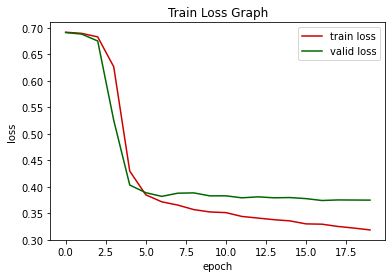

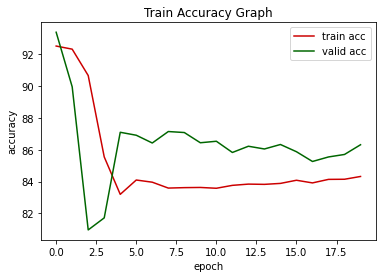

torch.Size([6393, 2])
tensor([[ 2.3890, -2.4029],
        [ 3.4876, -3.5257],
        [-1.9062,  1.8544],
        ...,
        [ 0.4049, -0.4010],
        [ 1.8738, -1.8739],
        [-1.1010,  1.0859]], dtype=torch.float64, grad_fn=<AddmmBackward>)
tensor([False, False,  True,  ..., False, False,  True])
0.47129909365558914


In [9]:
import matplotlib.pyplot as plt 

plt.title('Train Loss Graph')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(_est_loss['train'], color=(0.8,0.,0.), label='train loss')
plt.plot(_est_loss['valid'], color=(0.,0.4,0.), label='valid loss')
plt.legend()
plt.show()

plt.title('Train Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(_est_acc['train'], color=(0.8,0.,0.), label='train acc')
plt.plot(_est_acc['valid'], color=(0.,0.4,0.), label='valid acc')
plt.legend()
plt.show()

model.eval()
prediction = model.forward(xvalid_words[:,  : -1], xvalid_words[ : , -1]) # predicting on the validation set
prediction_int = prediction[:, 1] >= prediction[:, 0]
# prediction_int = prediction_int.numpy().astype(np.int)

print(prediction.shape)
print(prediction)
# print(yvalid)
print(prediction_int)
score = f1_score(yvalid, prediction_int) # calculating f1 score
print(score)

In [1]:
test_pred = model.forward(test_data[:,  : -1], test_data[ : , -1])
test_pred_int = test_pred[:, 1] >= test_pred[:, 0]
testData['label'] = test_pred_int
submission = testData[['id','label']]
submission.to_csv('../output/sub_lreg_bow.csv', index=False) # writing data to a CSV file

NameError: name 'model' is not defined

In [11]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11, 100)           4736100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,772,261
Trainable params: 36,161
Non-trainable params: 4,736,100
_________________________________________________________________


In [14]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

word_seq_train = word_seq[:31962, :]
word_seq_test = word_seq[31962:, :]
# es_callback = EarlyStopping(monitor='val_loss', patience=3)

# history = model.fit(word_seq_train, y_train, batch_size=1000,
#           epochs=num_epochs, validation_split=0.2, callbacks=[es_callback], shuffle=False)
history = model.fit(word_seq_train, y_train, batch_size=1000,
          epochs=num_epochs, validation_split=0.2, shuffle=False)

Epoch 1/100
26/26 [==============================] - 4s 52ms/step - loss: 0.0757 - accuracy: 0.9733 - val_loss: 0.1369 - val_accuracy: 0.9509
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0694 - accuracy: 0.9755 - val_loss: 0.1380 - val_accuracy: 0.9514
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0633 - accuracy: 0.9780 - val_loss: 0.1436 - val_accuracy: 0.9523
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0587 - accuracy: 0.9806 - val_loss: 0.1493 - val_accuracy: 0.9526
Epoch 5/100
26/26 [==============================] - 1s 27ms/step - loss: 0.0558 - accuracy: 0.9813 - val_loss: 0.1538 - val_accuracy: 0.9512
Epoch 6/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0510 - accuracy: 0.9827 - val_loss: 0.1607 - val_accuracy: 0.9528
Epoch 7/100
26/26 [==============================] - 1s 27ms/step - loss: 0.0473 - accuracy: 0.9846 - val_loss: 0.1681 - val_accuracy: 0.9514
Epoch 

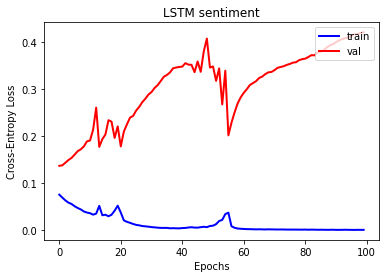

In [15]:

#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

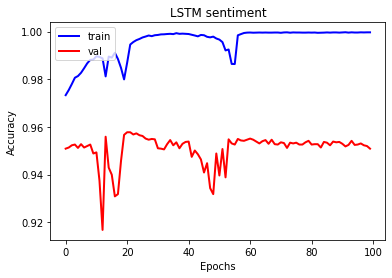

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:

predictions = model.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)
sample[['pred', "target"]]